In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit, DensityMatrix
from qulacs.gate import  X, H, Z, DepolarizingNoise, DephasingNoise, AmplitudeDampingNoise, TwoQubitDepolarizingNoise

In [37]:
#１次元横磁場イジング模型のハミルトニアンを定義
n_qubits = 7
transverse_Ising_hamiltonian = Observable(n_qubits)
J = -1.0
h = -1.0
for i in range(n_qubits):
    transverse_Ising_hamiltonian.add_operator(J, f"Z {i} Z {(i+1)%n_qubits}")
    transverse_Ising_hamiltonian.add_operator(h, f"X {i}")

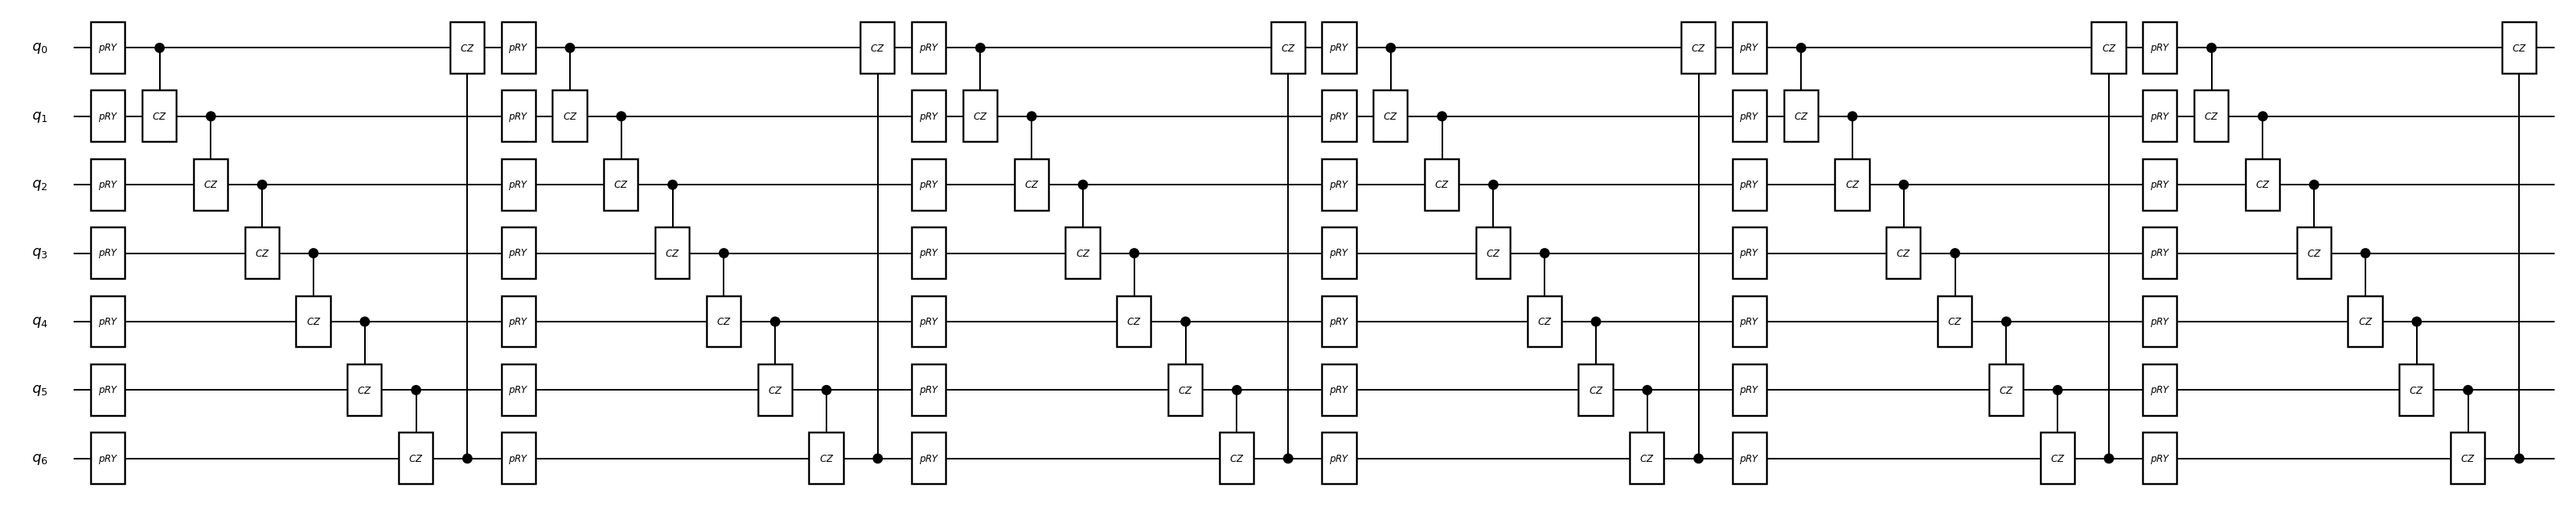

In [53]:
## まずはエラーなしの場合
from qulacsvis import circuit_drawer
from scipy.optimize import minimize

#状態ベクトル、ansatz回路を定義
state = QuantumState(n_qubits)
circuit_depth = 6
circuit = ParametricQuantumCircuit(n_qubits)

#ansatz回路を指定
def Circuit(n_qubits,circuit_depth):
    circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            circuit.add_parametric_RY_gate(i, 0.0)
        for i in range(n_qubits):
            circuit.add_CZ_gate(i, (i+1)%n_qubits)
    return circuit
circuit = Circuit(n_qubits,circuit_depth)
params = np.zeros(circuit.get_parameter_count())

#ansatz回路を表示
circuit_drawer(circuit, "mpl")

In [54]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def get_cost(params):
    state = QuantumState(n_qubits)
    for i, p in enumerate(params):
        circuit.set_parameter(i,p)
    circuit.update_quantum_state(state)
    return transverse_Ising_hamiltonian.get_expectation_value(state)

In [55]:
#上で定義したansatz回路のもとで、コスト関数を最小化する。
params_initial = np.zeros_like(params)
minimized_costfunction = minimize(get_cost, params_initial, method='BFGS')

#コスト関数の最小値を表示
print(minimized_costfunction.fun)

-8.89317239940372


In [56]:
#エラーがない場合のansatz回路のパラメータを取得
params_true = minimized_costfunction.x

In [57]:
## 次にdepolarizing noiseありの場合（１次元横磁場イジング模型）

#密度演算子、ansatz回路を定義
density_state = DensityMatrix(n_qubits)
noisy_circuit = ParametricQuantumCircuit(n_qubits)
error_rate = 0.01

#ansatz回路を指定
def NoisyCircuit(error_rate):
    noisy_circuit = ParametricQuantumCircuit(n_qubits)
    for d in range(circuit_depth):
        for i in range(n_qubits):
            noisy_circuit.add_parametric_RY_gate(i, 0.0)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
        for i in range(n_qubits):
            noisy_circuit.add_CZ_gate(i, (i+1)%n_qubits)
            noisy_circuit.add_gate(DepolarizingNoise(i, error_rate))
            noisy_circuit.add_gate(DepolarizingNoise((i+1)%n_qubits, error_rate))
    return noisy_circuit

noisy_circuit = NoisyCircuit(error_rate)

In [58]:
#コスト関数を定義。ここではエネルギー期待値がコスト関数。
def noisy_get_cost(params):
    density_state = DensityMatrix(n_qubits)
    for i, p in enumerate(params):
        noisy_circuit.set_parameter(i,p)
    noisy_circuit.update_quantum_state(density_state)
    return transverse_Ising_hamiltonian.get_expectation_value(density_state)

In [59]:
#エラーなし、エラーありの場合で期待値を計算
minimized_costfunction_noiseless = get_cost(params_true)
minimized_costfunction_noise = noisy_get_cost(params_true)

#コスト関数の最小値を表示
print(minimized_costfunction_noiseless)
print(minimized_costfunction_noise)

-8.893172399403724
-6.037387414064977


In [45]:
data_cost_depolarizingnoise = []
data_noise_strength = []
data_error_rate_per_gate = []

#エラー率を少しずつ変化させて、コスト関数を求める。
for i in range(20):
    error_rate=i*0.001
    total_error_rate = error_rate * (3.0*n_qubits) * circuit_depth
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise.append(minimized_costfunction_noise)
    data_noise_strength.append(total_error_rate)
    data_error_rate_per_gate.append(error_rate)

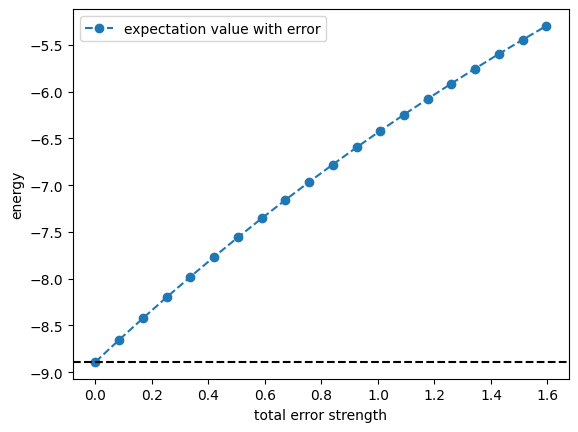

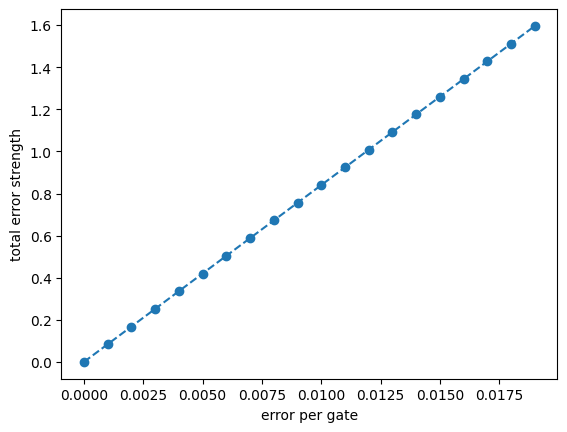

In [46]:
#コスト関数 vs エラー率のグラフ
plt.plot(data_noise_strength,data_cost_depolarizingnoise, marker="o", linestyle = "--", label=f"expectation value with error")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error strength")
plt.legend()
plt.show()

#（全ゲート数）×（エラー率） vs エラー率のグラフ
plt.plot(data_error_rate_per_gate,data_noise_strength, marker="o", linestyle = "--")
plt.ylabel("total error strength")
plt.xlabel("error per gate")
plt.show()

In [47]:
##error mitigation（外挿法）を実行する。リチャードソン外挿のうち、線形外挿をやってみる。
## ノイズに関するコスト関数のグラフ

data_cost_depolarizingnoise_alpha = []
data_cost_depolarizingnoise_linear_extrapolation = []
alpha = 1.5

for i in range(20):
    error_rate=i * 0.001 * alpha
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise_alpha.append(minimized_costfunction_noise)

for i in range(20):
    linear_extrapolation = (alpha*data_cost_depolarizingnoise[i]-data_cost_depolarizingnoise_alpha[i])/(alpha - 1.0)
    data_cost_depolarizingnoise_linear_extrapolation.append(linear_extrapolation)

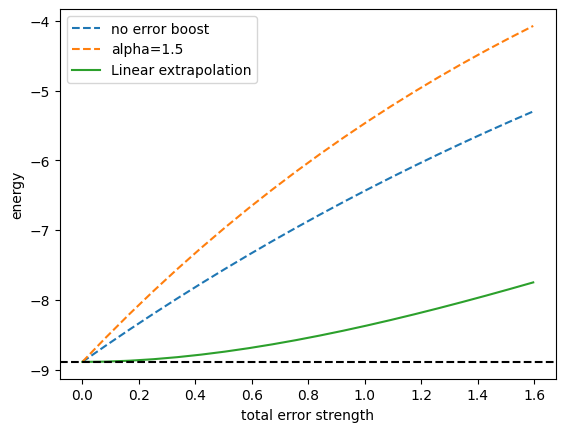

In [48]:
#線形外挿の結果を表示
plt.plot(data_noise_strength,data_cost_depolarizingnoise, label=f"no error boost",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha, label=f"alpha=1.5",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear extrapolation")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error strength")
plt.legend()
plt.show()

In [49]:
##error mitigation（外挿法）を実行する　その２（２次多項式で外挿）
## ノイズに関するコスト関数のグラフ
data_cost_depolarizingnoise_alpha2 = []
data_cost_depolarizingnoise_Richardson_extrapolation = []

alpha1 = alpha
alpha2 = 2.0

for i in range(20):
    error_rate=i*0.001*alpha2
    noisy_circuit = NoisyCircuit(error_rate)
    minimized_costfunction_noise = noisy_get_cost(params_true)
    data_cost_depolarizingnoise_alpha2.append(minimized_costfunction_noise)

for i in range(20):
    beta0 = (alpha1/(alpha1 - 1.0))*(alpha2/(alpha2 - 1.0))
    beta1 = ((1.0)/(1.0-alpha1))*(alpha2/(alpha2 - alpha1))
    beta2 = ((1.0)/(1.0-alpha2))*(alpha1/(alpha1 - alpha2))
    Richardson_extrapolation = beta0*data_cost_depolarizingnoise[i]+beta1*data_cost_depolarizingnoise_alpha[i]+beta2*data_cost_depolarizingnoise_alpha2[i]
    data_cost_depolarizingnoise_Richardson_extrapolation.append(Richardson_extrapolation)

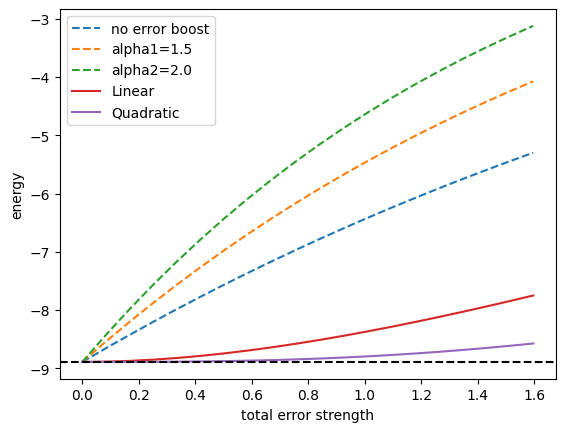

In [50]:
#実線が外挿した結果、点線はmitigationしていない結果
plt.plot(data_noise_strength,data_cost_depolarizingnoise, label=f"no error boost",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha, label=f"alpha1=1.5",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_alpha2, label=f"alpha2=2.0",linestyle="dashed")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Richardson_extrapolation, label=f"Quadratic")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error strength")
plt.legend()
plt.show()

In [51]:
##error mitigation（指数関数外挿法）を実行する　その３
## ノイズに関するコスト関数のグラフ
##指数関数外挿とリチャードソン外挿は測定後のデータ処理の違いのみであることに注意

data_cost_depolarizingnoise_Exponential_extrapolation = []
data_cost_depolarizingnoise_Exponential_extrapolation_alpha2 = []

for i in range(20):
    Exponential_extrapolation = data_cost_depolarizingnoise[i]**(alpha1/(alpha1 - 1.0)) * data_cost_depolarizingnoise_alpha[i]**(1.0/(1.0-alpha1))
    data_cost_depolarizingnoise_Exponential_extrapolation.append(Exponential_extrapolation)

for i in range(20):
    Exponential_extrapolation = data_cost_depolarizingnoise[i]**2/data_cost_depolarizingnoise_alpha2[i]
    data_cost_depolarizingnoise_Exponential_extrapolation_alpha2.append(Exponential_extrapolation)


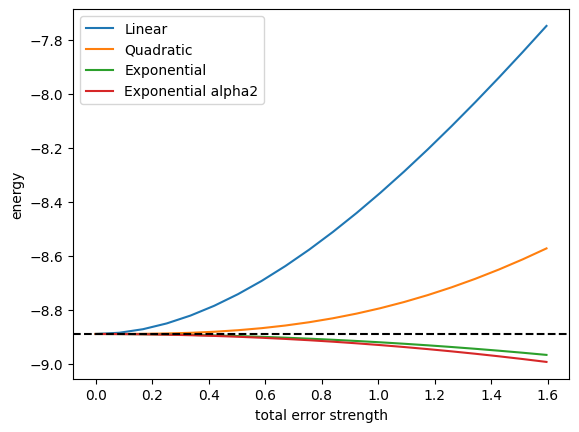

In [52]:
#それぞれ外挿した結果を表示
plt.plot(data_noise_strength,data_cost_depolarizingnoise_linear_extrapolation, label=f"Linear")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Richardson_extrapolation, label=f"Quadratic")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Exponential_extrapolation, label=f"Exponential")
plt.plot(data_noise_strength,data_cost_depolarizingnoise_Exponential_extrapolation_alpha2, label=f"Exponential alpha2")
plt.axhline(minimized_costfunction_noiseless, color="black", linestyle="dashed")
plt.ylabel("energy")
plt.xlabel("total error strength")
plt.legend()
plt.show()